In [1]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import warnings
import random
import pickle
import json
import os

from IPython.core.interactiveshell import InteractiveShell

from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
data = create_date_features(data)

In [4]:
# drop columns with big share of missing values
data = remove_null_columns(data, threshold=.999)

In [5]:
def get_train_valid_test_split(data):
    X = data.drop(columns=['target', 'client_id', 'report_date'])
    Y = data['target']

    categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

    X[numerical_columns] = X[numerical_columns].fillna(0)
    X[categorical_columns] = X[categorical_columns].astype(str)

    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True, stratify=Y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.33, random_state=42, shuffle=True,
                                                        stratify=y_valid)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [6]:
def get_train_valid_test_split_group(data):
    splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state=7)
    split = splitter.split(data, groups=data['client_id'])
    train_inds, test_inds = next(split)

    split = splitter.split(data.iloc[test_inds], groups=data.iloc[test_inds]['client_id'])
    valid_inds, test_inds = next(split)

    train = data.iloc[train_inds]
    valid = data.iloc[valid_inds]
    test = data.iloc[test_inds]

    X_train = train.drop(columns=['target', 'client_id', 'report_date'])
    X_valid = valid.drop(columns=['target', 'client_id', 'report_date'])
    X_test = test.drop(columns=['target', 'client_id', 'report_date'])

    y_train = train['target']
    y_valid = valid['target']
    y_test = test['target']

    categorical_columns = data.drop(columns=['target', 'client_id', 'report_date']).select_dtypes(exclude=['float64', 'int64']).columns
    numerical_columns = data.drop(columns=['target', 'client_id', 'report_date']).select_dtypes(include=['float64', 'int64']).columns
    X_train[numerical_columns] = X_train[numerical_columns].fillna(0)
    X_train[categorical_columns] = X_train[categorical_columns].astype(str)

    X_valid[numerical_columns] = X_valid[numerical_columns].fillna(0)
    X_valid[categorical_columns] = X_valid[categorical_columns].astype(str)

    X_test[numerical_columns] = X_test[numerical_columns].fillna(0)
    X_test[categorical_columns] = X_test[categorical_columns].astype(str)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [7]:
# X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split(data)

In [8]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split_group(data)

In [9]:
# X = data.drop(columns=['target', 'client_id', 'report_date'])
# Y = data['target']

In [10]:
# categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
# numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

In [11]:
# X[numerical_columns] = X[numerical_columns].fillna(0)
# X[categorical_columns] = X[categorical_columns].astype(str)

In [12]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True, stratify=Y)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.33, random_state=42, shuffle=True,
#                                                     stratify=y_valid)

# Stage 2. Data Analysis

### Data Inspection

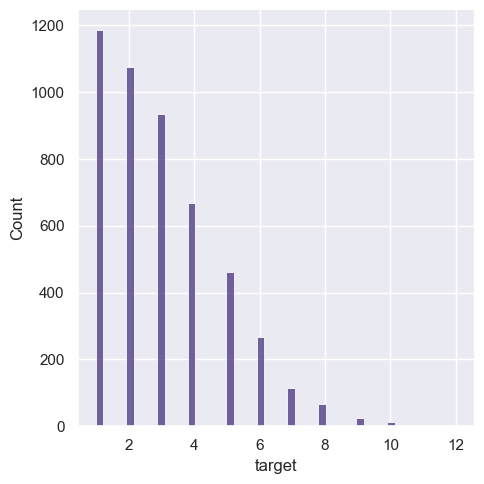

In [13]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [14]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

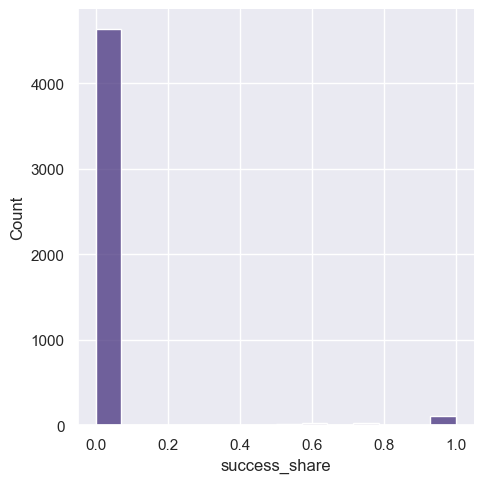

In [15]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

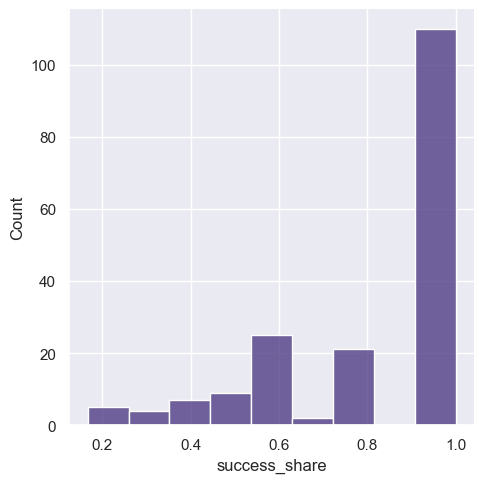

In [16]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [17]:
# share of clents with 1
(
    data[['client_id', 'target']]
    .groupby('target', as_index=True)
    .agg(qnt=('client_id', 'count'))
)

,qnt
target,
0,14020
1,436


### Plot Possible Clusters

In [18]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [19]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

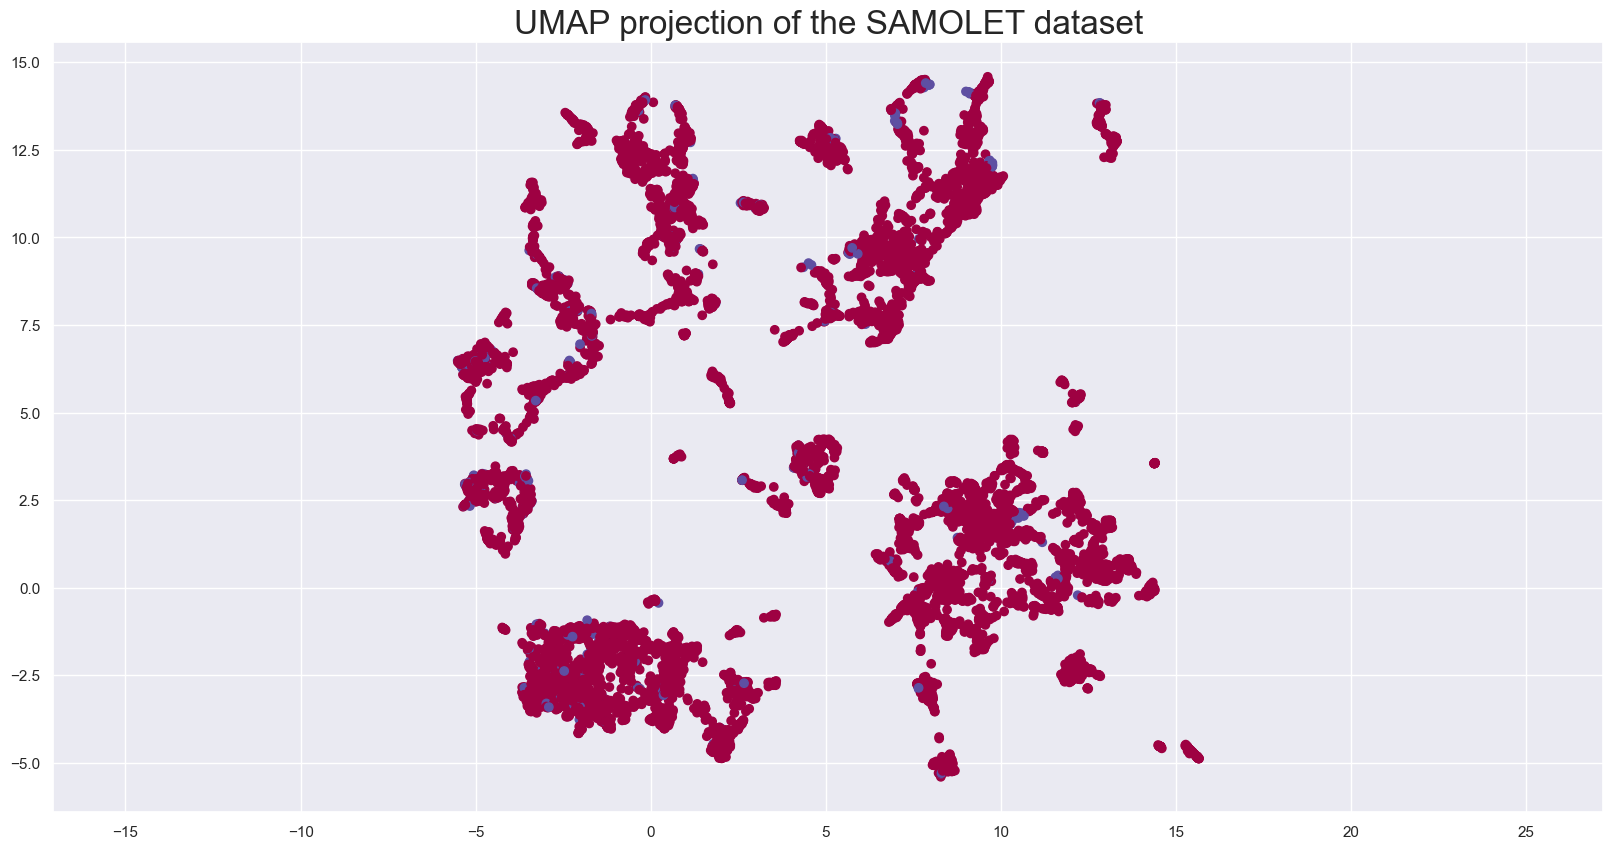

In [20]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [21]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [22]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [23]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

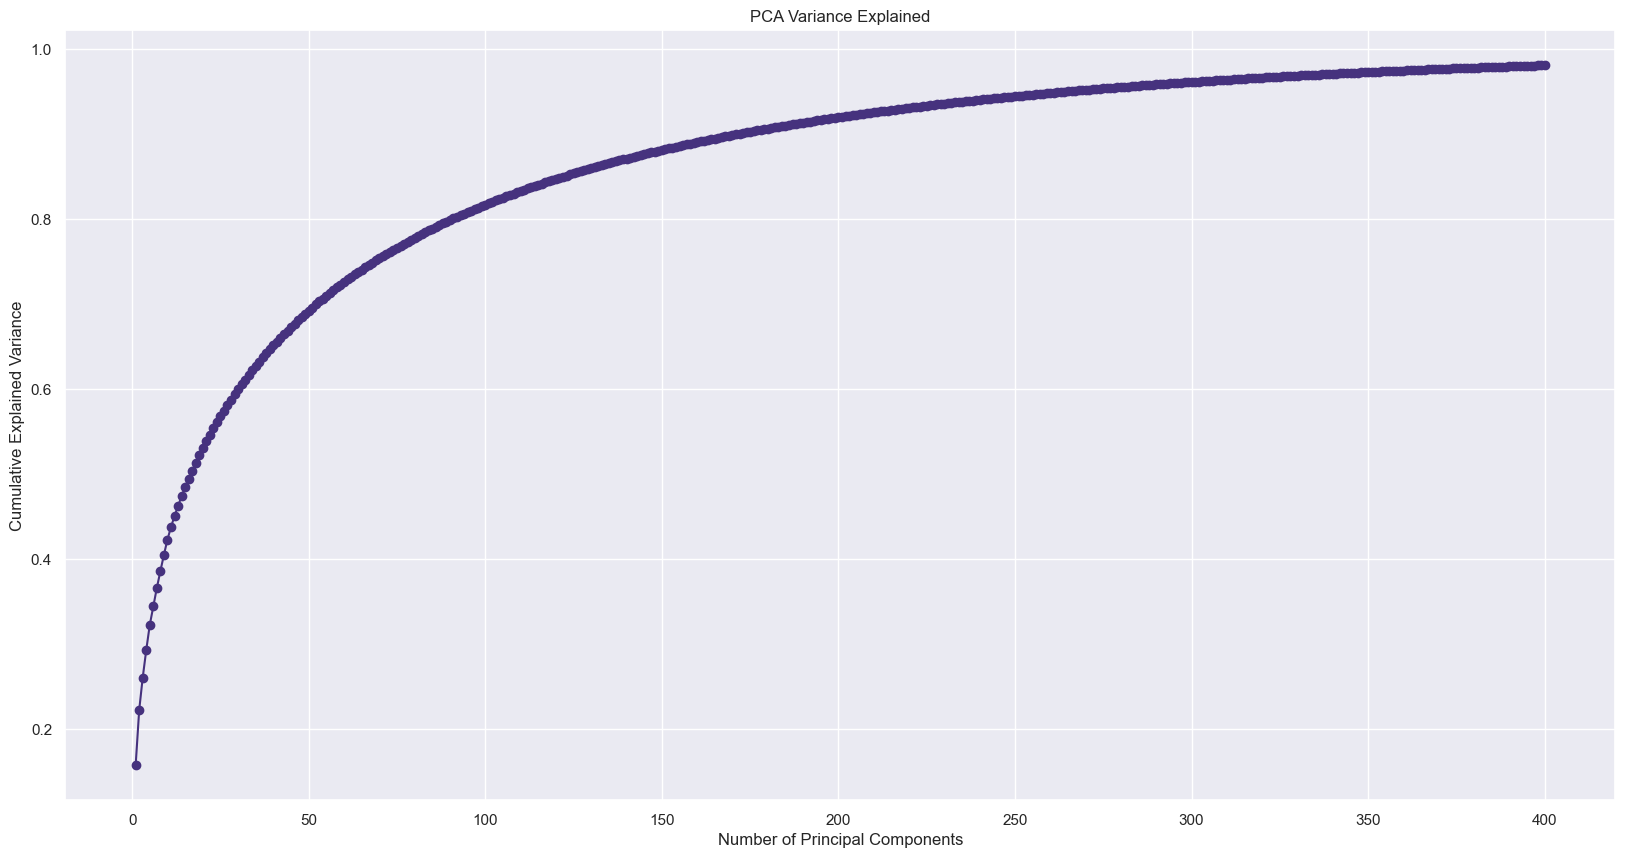

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [24]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

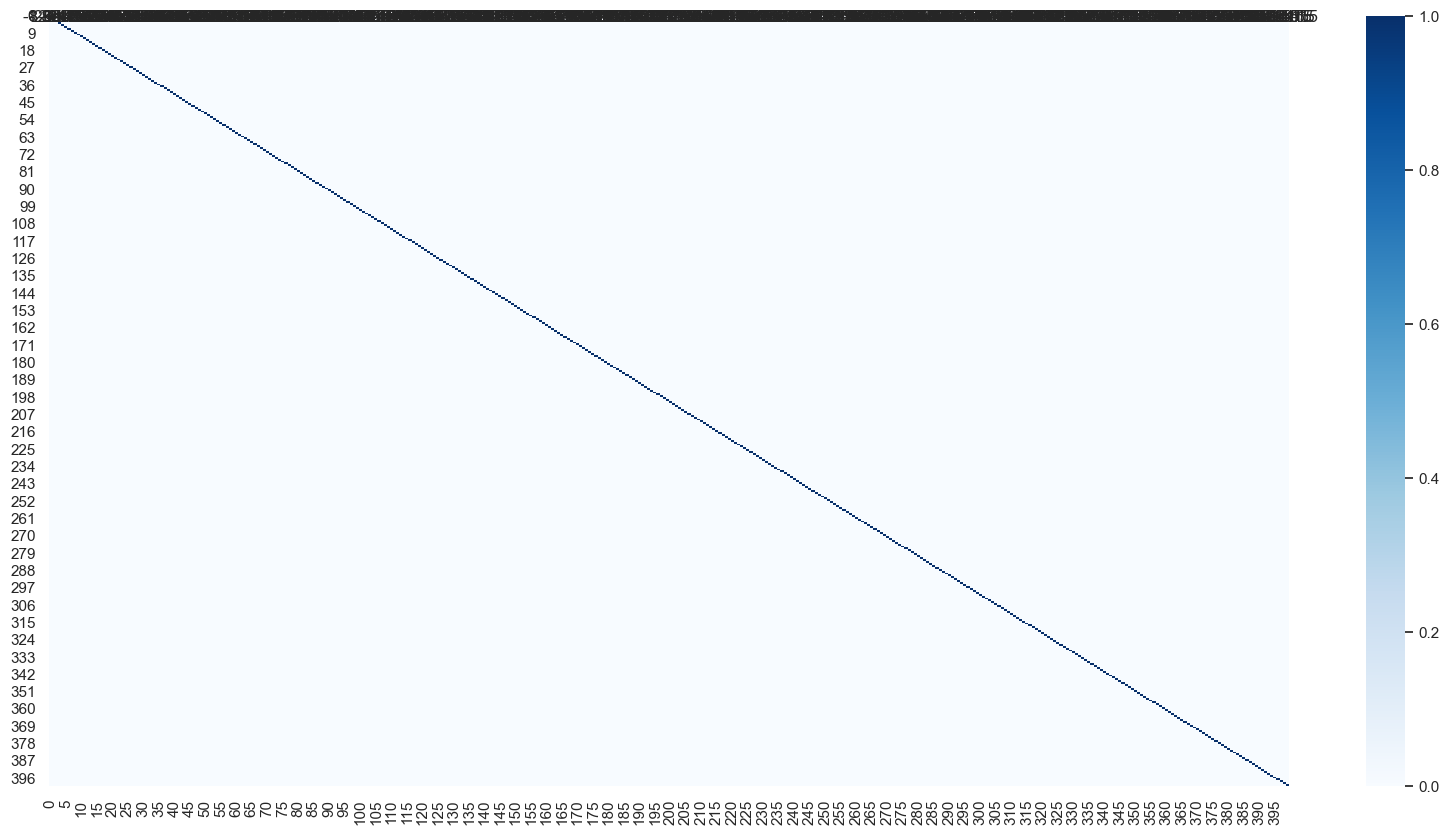

In [25]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [26]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9004792644757432

ROC-AUC score is:  0.9004792644757432


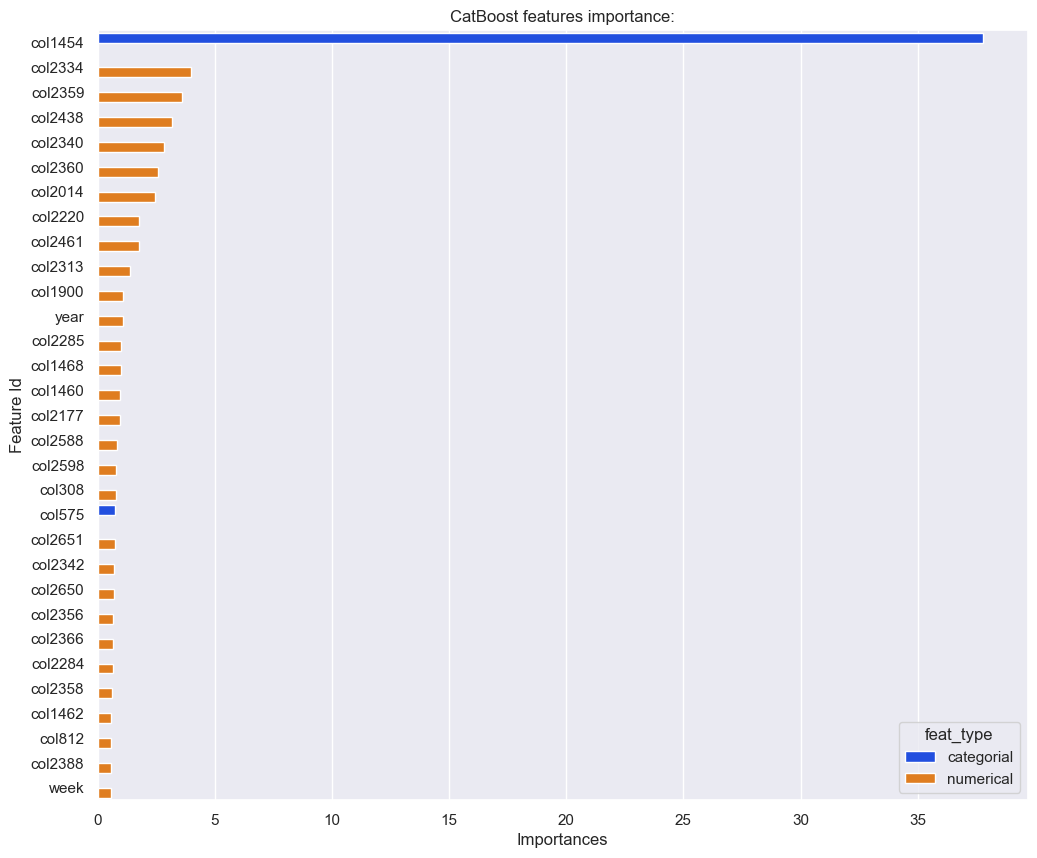

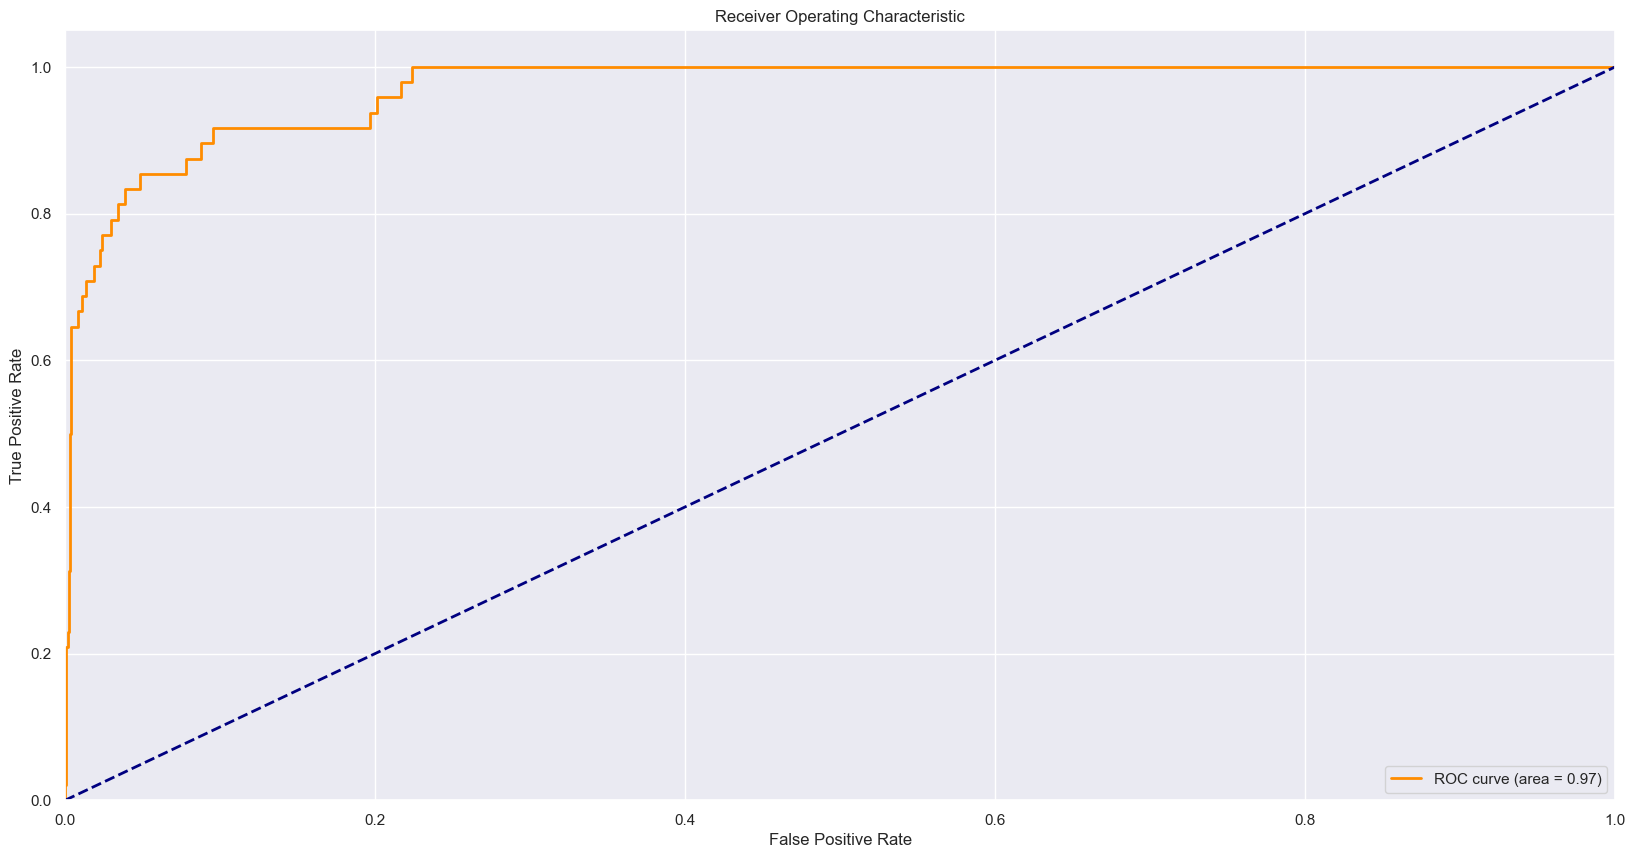

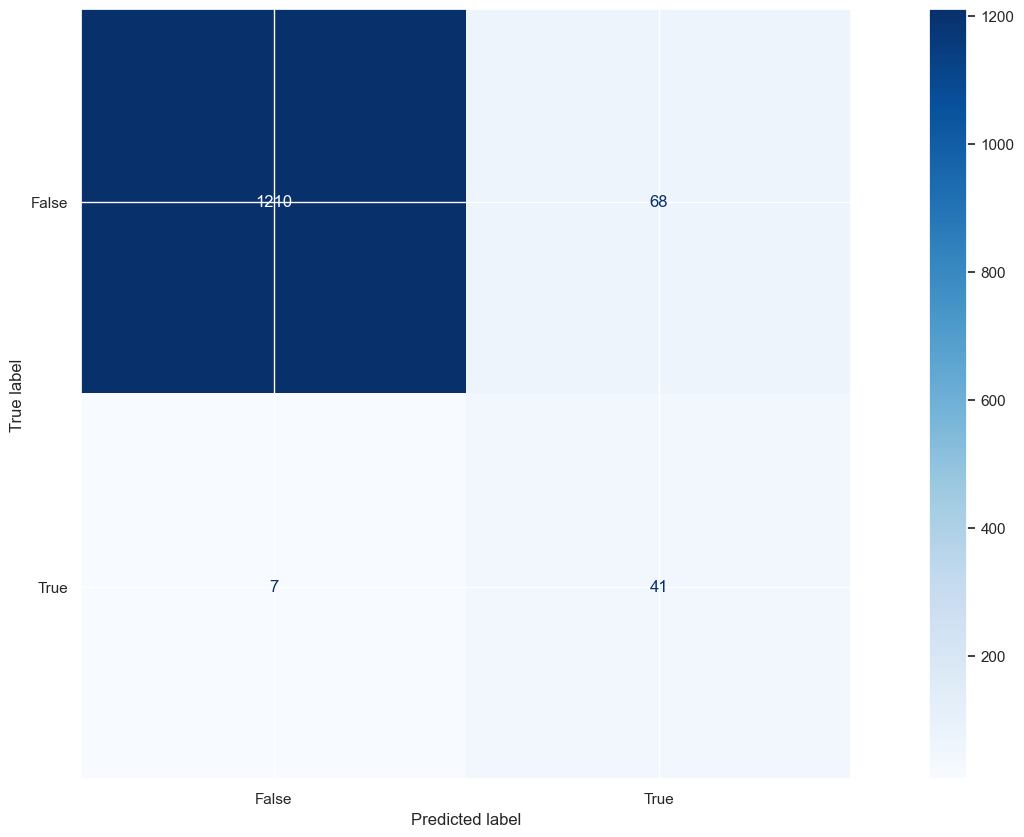

In [27]:
plot_model_info(model, X_test, y_test)  #categorical_columns

# Step 4. Feature Selection

In [60]:
def get_features_importance_rand_feaut(X_train, y_train, X_valid, y_valid):
    # Add a random feature
    X_train["random"] = np.random.random(size=len(X_train))
    X_valid["random"] = np.random.random(size=len(X_valid))

    # Get categorical features
    categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(X_train, categorical_columns)

    model = CatBoostClassifier(
        loss_function='Logloss',
        random_seed=42,
        logging_level='Silent',
        max_depth=8,
        iterations=200,
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
    )
    # Train the model
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        cat_features=categorical_features_indices,
    )

    # Get feature importance
    importance = model.feature_importances_

    # Create a dictionary that maps feature names to their importance
    features_importance = {
        name: importance for name, importance in zip(X_train.columns, importance)
    }

    return features_importance


def get_random_feat_important_features(X_train, y_train, X_valid, y_valid):
    feat_importance = get_features_importance_rand_feaut(X_train, y_train, X_valid, y_valid)
    feat_importance = pd.DataFrame.from_records(
        [feat_importance],
    ).transpose().rename(columns={0:'AVG_Importance'})
    useful_column_indices = get_column_indices(
        X_train,
        feat_importance.query("AVG_Importance > 0 ")["AVG_Importance"].index.to_list(),)

In [ ]:
# useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=True)
useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)

In [ ]:
useful_column_indices_rf

In [ ]:
X_train_cleaned = X_train.iloc[:, useful_column_indices_sk]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices_sk]
X_test_cleaned = X_test.iloc[:, useful_column_indices_sk]

In [ ]:
# def catboost_model_classifier(x_train, x_valid, y_train, y_valid):
#     # categorical_features_indices = np.where(~X_train.dtypes.isin(['float64', 'int64']))[0]
#     categorical_columns = x_train.select_dtypes(exclude=["float64", "int64"]).columns
#     numerical_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
#     categorical_features_indices = get_column_indices(x_train, categorical_columns)
# 
#     x_train[numerical_columns] = x_train[numerical_columns].fillna(0).astype(int)
#     x_valid[numerical_columns] = x_valid[numerical_columns].fillna(0).astype(int)
# 
#     x_train[categorical_columns] = x_train[categorical_columns].astype(str)
#     x_valid[categorical_columns] = x_valid[categorical_columns].astype(str)
# 
#     cb_model = CatBoostClassifier(
#         loss_function="Logloss",
#         random_seed=42,
#         logging_level="Silent",
#         # custom_metric=['MAE', 'MAPE'],
#         max_depth=8,
#         iterations=200,
#         # scale_pos_weight=26,
#         auto_class_weights="Balanced",
#         early_stopping_rounds=20,
#         # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
#     )
# 
#     if len(categorical_columns) > 0:
#         cb_model.fit(
#             x_train,
#             y_train,
#             eval_set=(x_valid, y_valid),
#             cat_features=categorical_columns.to_list(),
#             plot=True,
#         )
#     else:
#         cb_model.fit(
#             x_train,
#             y_train,
#             eval_set=(x_valid, y_valid),
#             cat_features=categorical_columns.to_list(),
#             plot=True,
#         )
# 
#     return cb_model

In [ ]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

In [ ]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
    # X_test_cleaned.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
)

# Step 5. Hyperparameters Tuning

In [ ]:
search_new_params = True
if search_new_params:
    hyperparams = search_best_params(X_train_cleaned, X_test_cleaned, y_train, y_test, max_evals=100)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

In [ ]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [ ]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [ ]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best = CatBoostClassifier(**params)
model_best.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

In [ ]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 6. Add Logistic Regression

In [ ]:
# def get_transformer_data_for_regression(X):
#     # "Cardinality" means the number of unique values in a column
#     # Select categorical columns with relatively low cardinality (convenient but arbitrary)
#     categorical_cols = [
#         cname
#         for cname in X.columns
#         if X[cname].nunique() < 10 and X[cname].dtype == "object"
#     ]
# 
#     # Select numerical columns
#     numerical_cols = [
#         cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
#     ]
# 
#     # Preprocessing for numerical data
#     numerical_transformer = Pipeline(
#         steps=[
#             ("imputer", SimpleImputer(strategy="constant")),
#             ("scaler", StandardScaler()),
#             (
#                 "poly",
#                 PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
#             ),
#         ]
#     )
# 
#     # Preprocessing for categorical data
#     categorical_transformer = Pipeline(
#         steps=[
#             ("imputer", SimpleImputer(strategy="most_frequent")),
#             ("onehot", OneHotEncoder(handle_unknown="ignore")),
#         ]
#     )
# 
#     # Bundle preprocessing for numerical and categorical data
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ("num", numerical_transformer, numerical_cols),
#             ("cat", categorical_transformer, categorical_cols),
#         ]
#     )
#     preprocessor.fit_transform(X)
#     return preprocessor

In [ ]:
preprocessor = get_transformer_data_for_regression(X_train_cleaned)
# preprocessor.fit(X_train_cleaned)

In [ ]:
X_train_linear = preprocessor.transform(X_train_cleaned)
X_test_linear = preprocessor.transform(X_test_cleaned)

In [ ]:
pca = PCA(n_components=min(100, len(X_train_cleaned.columns)), svd_solver='full')
pca.fit(X_train_linear)
plot_pca_variance(pca)

In [ ]:
top_n = 60
train_pca = pca.fit_transform(X_train_linear)[:, :top_n]  # we select only top N features
test_pca = pca.transform(X_test_linear)[:, :top_n]

### LogisticRegression

In [ ]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(train_pca, y_train)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

### LogisticRegressionCV

In [ ]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=42, class_weight='balanced')
logreg_cv.fit(train_pca, y_train)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_cv.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV